# Model Training

In [2]:
import tensorflow as tf

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
batchSize = 50
numClass = 10
epochs = 12

img_rows, img_cols = 28, 28

In [5]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [6]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

In [7]:
y_train = keras.utils.to_categorical(y_train, numClass)
y_test = keras.utils.to_categorical(y_test, numClass)

In [8]:
model = Sequential()
model.add(Conv2D(5, kernel_size=(5,5), \
                 activation='relu', input_shape=input_shape, \
                 padding='same', name='layer0'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(5, (5,5), activation='relu', padding='same', name='layer1'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(20, (5,5), activation='relu', padding='same', name='layer2'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(numClass, activation='softmax'))

In [9]:
model.compile(loss=keras.losses.categorical_crossentropy, \
              optimizer=keras.optimizers.Adadelta(), \
              metrics=['accuracy'])

In [10]:
model.fit(x_train, y_train, batch_size=batchSize, epochs=epochs, \
          verbose=1, validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)

Epoch 1/12
1200/1200 [==============================] - 22s 18ms/step - loss: 2.3091 - accuracy: 0.1035 - val_loss: 2.3018 - val_accuracy: 0.1021
Epoch 2/12
1200/1200 [==============================] - 21s 17ms/step - loss: 2.3029 - accuracy: 0.1118 - val_loss: 2.2948 - val_accuracy: 0.1415
Epoch 3/12
1200/1200 [==============================] - 20s 17ms/step - loss: 2.2969 - accuracy: 0.1199 - val_loss: 2.2878 - val_accuracy: 0.1934
Epoch 4/12
1200/1200 [==============================] - 21s 17ms/step - loss: 2.2903 - accuracy: 0.1322 - val_loss: 2.2805 - val_accuracy: 0.2338
Epoch 5/12
1200/1200 [==============================] - 21s 17ms/step - loss: 2.2849 - accuracy: 0.1416 - val_loss: 2.2726 - val_accuracy: 0.2691
Epoch 6/12
1200/1200 [==============================] - 21s 17ms/step - loss: 2.2782 - accuracy: 0.1517 - val_loss: 2.2637 - val_accuracy: 0.2917
Epoch 7/12
1200/1200 [==============================] - 22s 18ms/step - loss: 2.2707 - accuracy: 0.1652 - val_loss: 2.2532 -

In [11]:
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

Test loss:  2.1609363555908203
Test accuracy:  0.5178999900817871


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer0 (Conv2D)              (None, 28, 28, 5)         130       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 5)         0         
_________________________________________________________________
layer1 (Conv2D)              (None, 14, 14, 5)         630       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 5)           0         
_________________________________________________________________
layer2 (Conv2D)              (None, 7, 7, 20)          2520      
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 20)          0         
_________________________________________________________________
flatten (Flatten)            (None, 980)               0

In [129]:
model.save('../keras')

# Filter Visualization

In [23]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [107]:
def predict(idx, verbose=False):
    img = x_test[idx]
    label = y_test[idx]

    predict = model.predict_proba(np.expand_dims(img, axis=0))
    if verbose:
        print(f'Index: {idx}')
        cnt = 0
        for i in predict[0]:
            print('[{}] {:.2%}'.format(cnt, i))
            cnt += 1
        print('Predicted: ', predict[0].argmax())
        print('Label: ', label.argmax())
        plt.imshow(np.reshape(img, [28, 28]),interpolation='nearest', cmap='gray')
    return (predict[0].argmax(), label.argmax())

In [15]:
feature_extractor = keras.Model(inputs=model.inputs, \
                                outputs=[layer.output for layer in model.layers])

def get_hidden_layers(idx, _benchmark_=False):
    if _benchmark_:
        image = tf.convert_to_tensor(np.expand_dims(benchmark[idx], axis=0))
    else:
        image = tf.convert_to_tensor(np.expand_dims(x_test[idx], axis=0))
    features = feature_extractor(image)
    return features[0], features[2], features[4]

In [94]:
import math

def plotNNFilter(feature):
    feature = K.eval(feature)
    filters = feature.shape[3]  # number of filters
    plt.figure(1, figsize=(20,20))
    n_columns = 5
    n_rows = math.ceil(filters / n_columns) + 1

    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(feature[0,:,:,i], interpolation='nearest', cmap='gray')

In [17]:
### Create benchmarks
# Take average of all the train images for each label.

In [18]:
from collections import defaultdict

label_class = defaultdict(list)
for i in range(y_train.shape[0]):
    label_class[y_train[i].argmax()].append(i)

In [19]:
# list of x_train data(28, 28, 1) for each label
lst = []
for j in range(10):
    lst.append([x_train[i] for i in label_class[j]])

In [20]:
# list of benchmarks for each label
benchmark = []
for i in range(10):
    tmp = []
    for j in range(len(lst[i])):
        tmp.append(lst[i][j])
    benchmark.append(np.mean(np.array(tmp), axis=0))

In [21]:
# dictionary of mal-predicted indices 
wrong = {}

for i in range(x_test.shape[0]):
    pred = predict(i)
    if pred[0] != pred[1]:
        wrong[i] = (pred[0], pred[1])

W0627 20:18:36.319951 140734804516288 deprecation.py:323] From <ipython-input-14-a11727469b5b>:5: Sequential.predict_proba (from tensorflow.python.keras.engine.sequential) is deprecated and will be removed after 2021-01-01.
Instructions for updating:
Please use `model.predict()` instead.


In [22]:
# compare and contrast by tensor subtraction
def plotCompare(feature1, feature2):
    if feature1.shape != feature2.shape:
        print("Shapes don't match")
        return

    feature1 = K.eval(feature1)
    feature2 = K.eval(feature2)
    filters = feature1.shape[3]  # number of filters
    plt.figure(1, figsize=(20,20))
    n_columns = 5
    n_rows = math.ceil(filters / n_columns) + 1

    for i in range(filters):
        gap = tf.math.abs(tf.math.subtract(feature1[0,:,:,i], feature2[0,:,:,i]))
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(gap, interpolation='nearest', cmap='gray')

In [ ]:
### Interactive Widget

In [75]:
import ipywidgets as widgets
from ipywidgets import interact_manual
import seaborn as sns

In [47]:
choice = []
for k, v in wrong.items():
    string = '%d) predicted: %d, label: %d' %(k, v[0], v[1])
    choice.append(string)

In [96]:
@interact_manual
def filterViz(Image = choice, Layer = [0, 1, 2]):
    i = Image.split(')')
    idx = int(i[0])
    i = Image.split(',')
    predicted = int(i[0][-1])
    answer = int(i[1][-1])
    
    hiddens = get_hidden_layers(idx)    
    hiddens_p = get_hidden_layers(predicted, True)
    hiddens_a = get_hidden_layers(answer, True)
    
    %matplotlib inline
    sns.set_style('darkgrid')
    
    fig1 = plt.figure(1)
    fig1.suptitle(f'Predicted to be {predicted}; Answer is {answer}', fontsize=20)
    predict(idx, True)

    fig2 = plt.figure(2)
    fig2.suptitle(f'Hidden layer{Layer} of benchmark {predicted}', fontsize=20)
    #plotNNFilter(hiddens[Layer])
    
    fig3 = plt.figure(3)
    fig3.suptitle(f'Hidden layer{Layer} of benchmark {answer}', fontsize=20)
    #plotNNFilter(hiddens_p[Layer])

    plt.show()

interactive(children=(Dropdown(description='Image', options=('1) predicted: 8, label: 2', '4) predicted: 8, la…

### Layer 0

Index: 1
[0] 10.88%
[1] 9.74%
[2] 9.88%
[3] 10.21%
[4] 8.92%
[5] 9.07%
[6] 11.45%
[7] 9.29%
[8] 11.65%
[9] 8.90%
Predicted:  8
Label:  2


(8, 2)

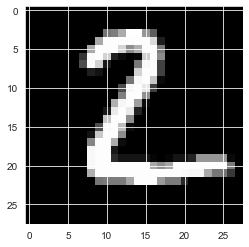

In [108]:
predict(list(wrong.keys())[0], True)

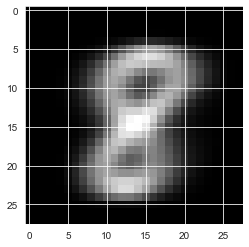

In [126]:
plt.imshow(np.reshape(benchmark[8], [28, 28]),interpolation='nearest', cmap='gray')

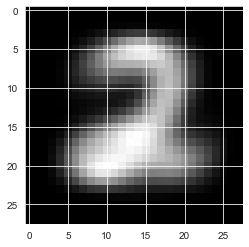

In [127]:
plt.imshow(np.reshape(benchmark[2], [28, 28]),interpolation='nearest', cmap='gray')

In [111]:
hiddens=get_hidden_layers(1)
hiddens8=get_hidden_layers(8, True)
hiddens2=get_hidden_layers(2, True)

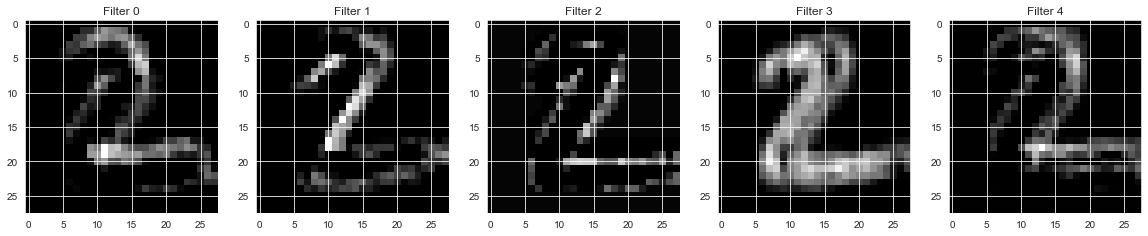

In [110]:
plotNNFilter(hiddens[0])

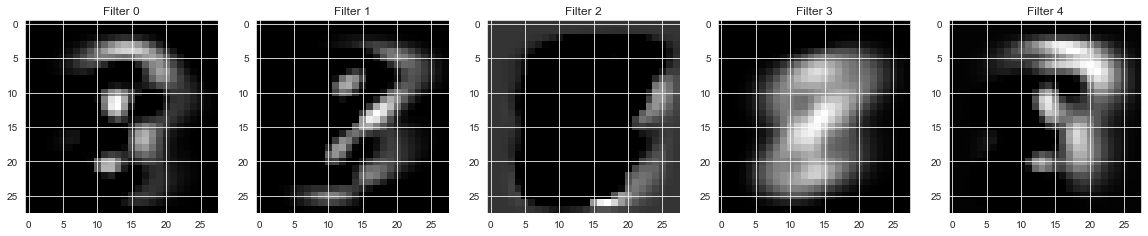

In [112]:
plotNNFilter(hiddens8[0])

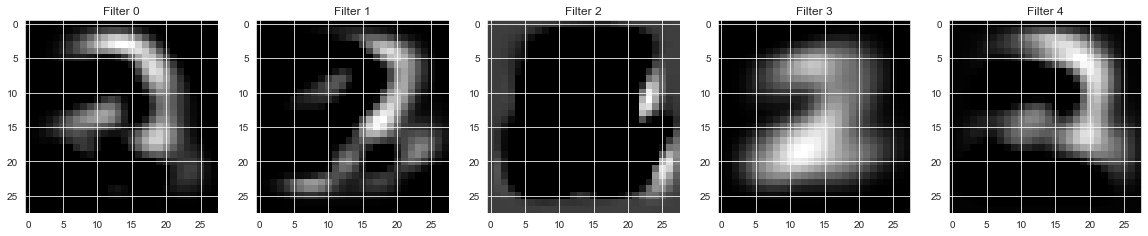

In [113]:
plotNNFilter(hiddens2[0])

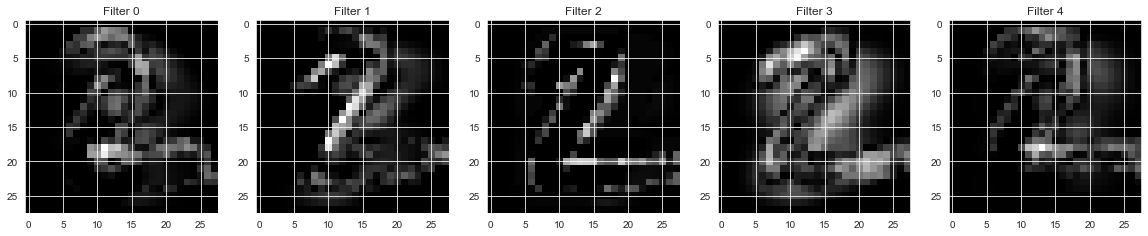

In [114]:
plotCompare(hiddens8[0], hiddens[0])

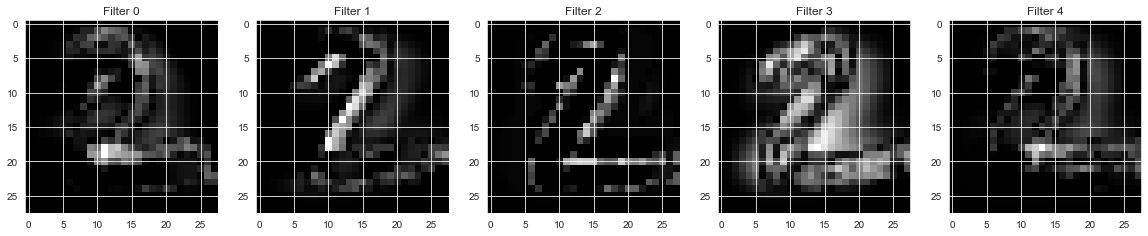

In [115]:
plotCompare(hiddens2[0], hiddens[0])

### Layer 1

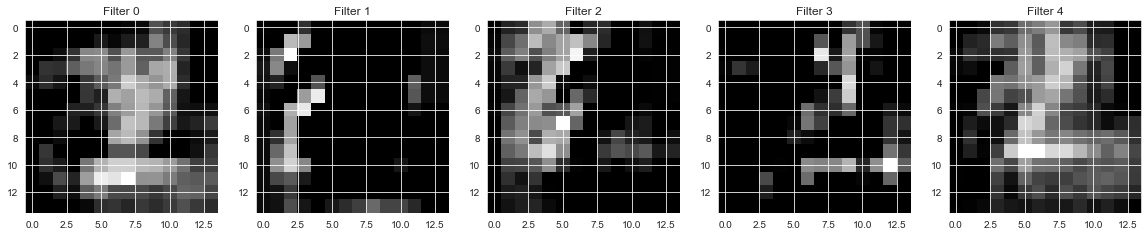

In [116]:
plotNNFilter(hiddens[1])

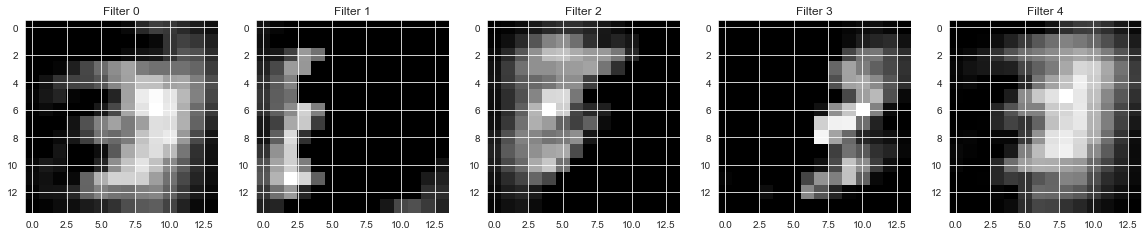

In [117]:
plotNNFilter(hiddens8[1])

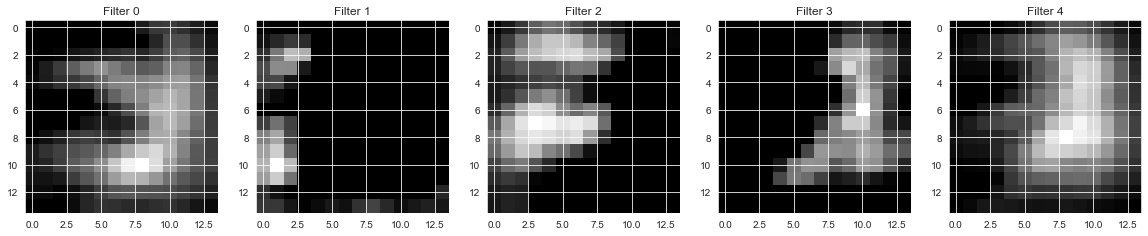

In [118]:
plotNNFilter(hiddens2[1])

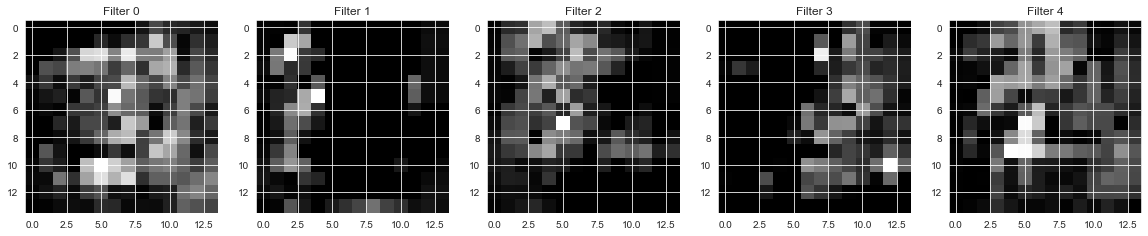

In [119]:
plotCompare(hiddens8[1], hiddens[1])

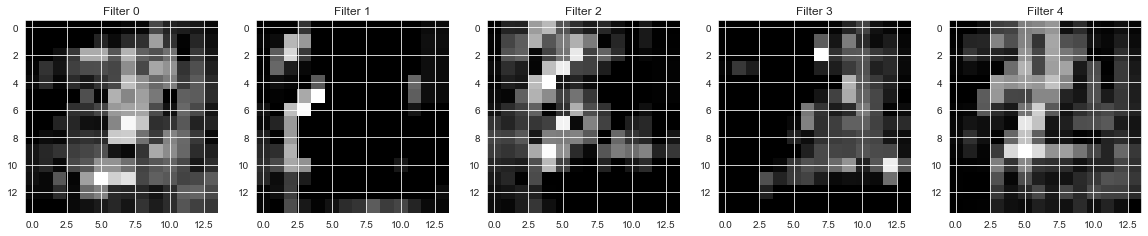

In [120]:
plotCompare(hiddens2[1], hiddens[1])

### Layer 2

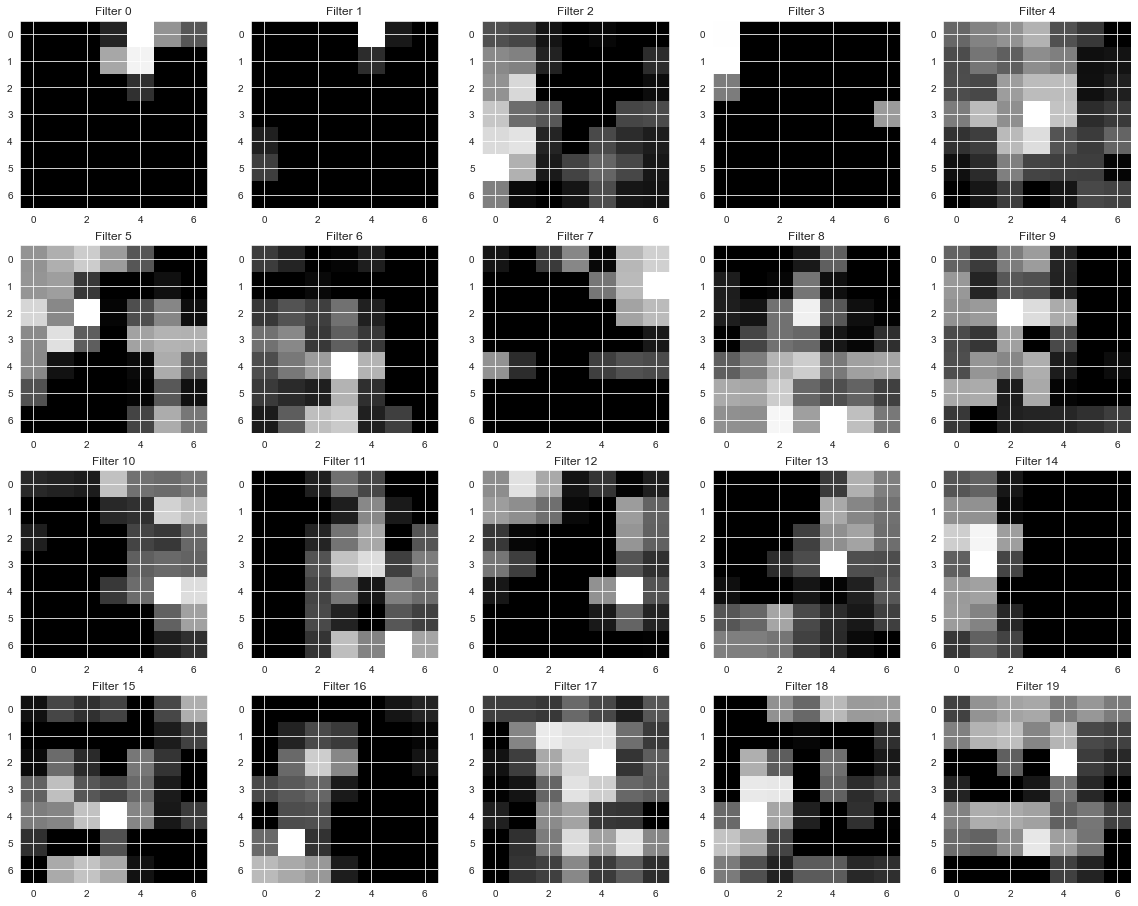

In [121]:
plotNNFilter(hiddens[2])

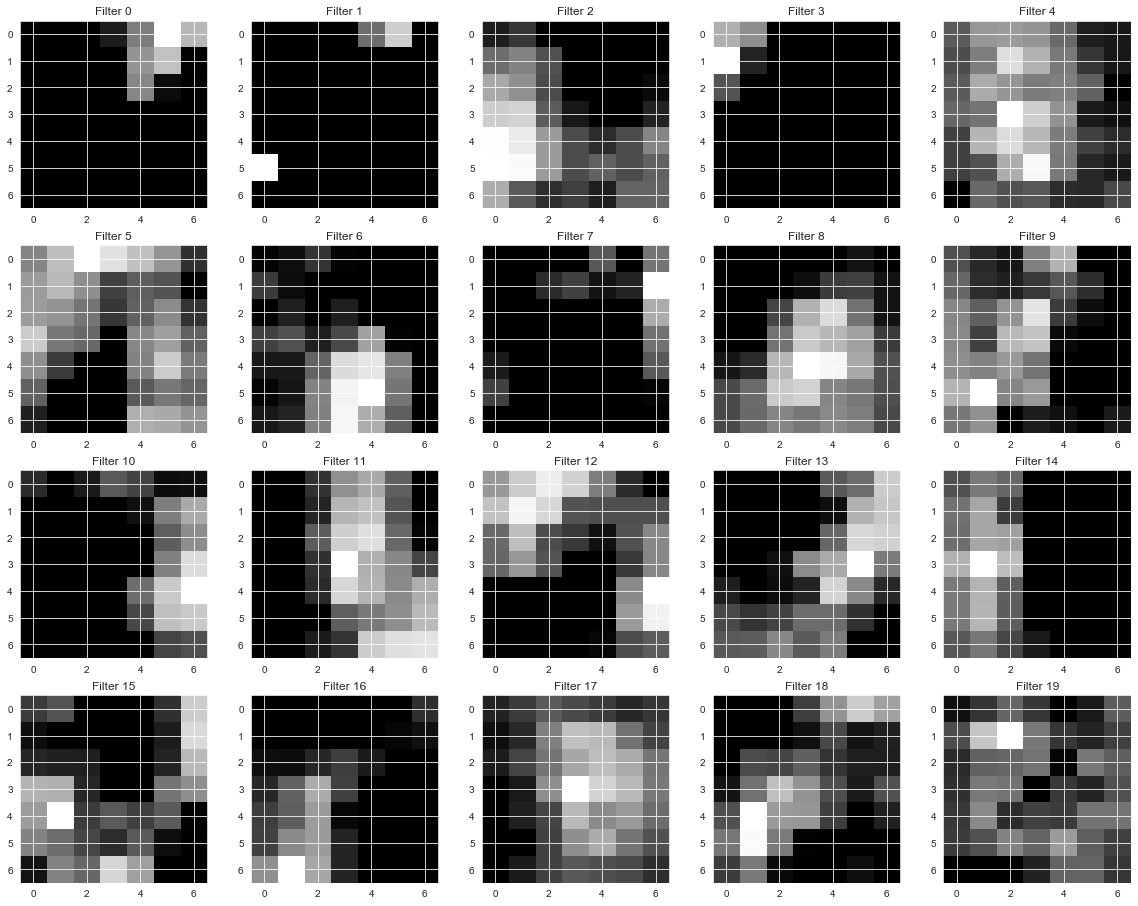

In [122]:
plotNNFilter(hiddens8[2])

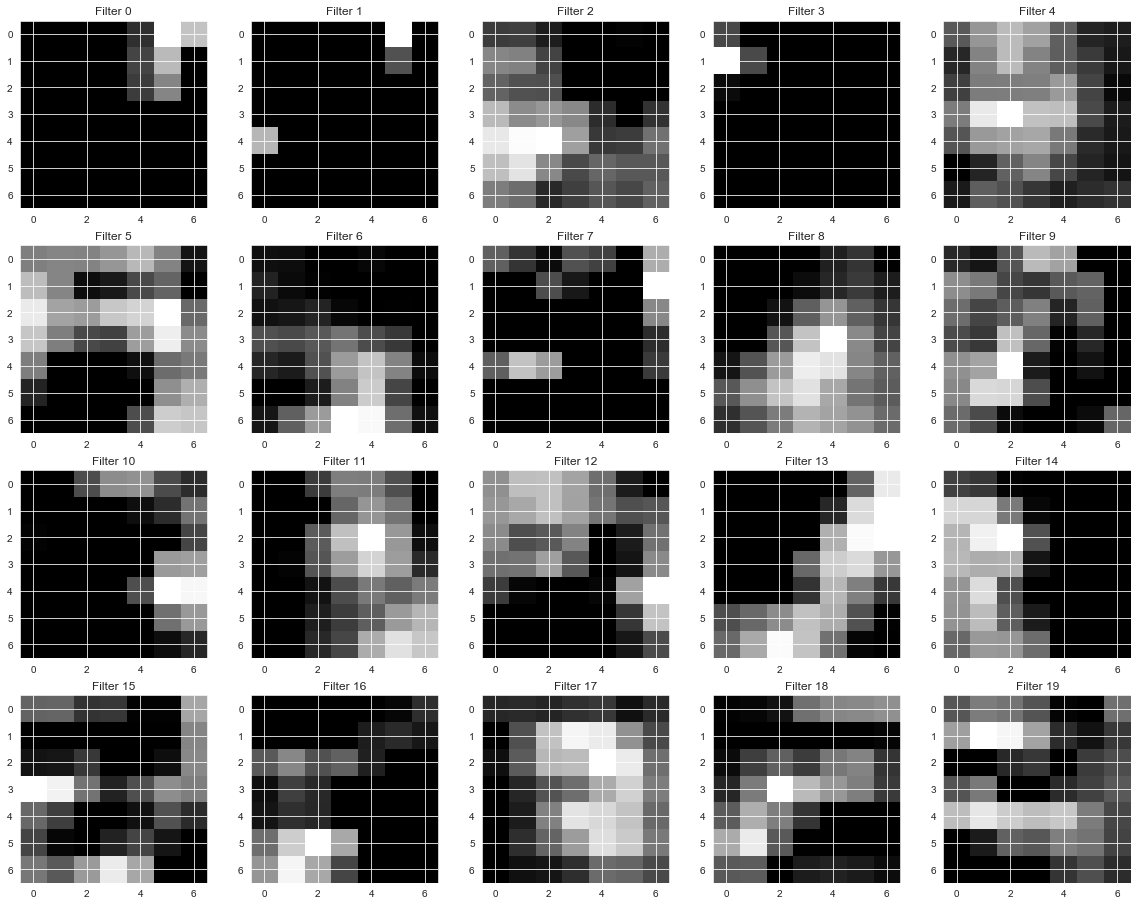

In [123]:
plotNNFilter(hiddens2[2])

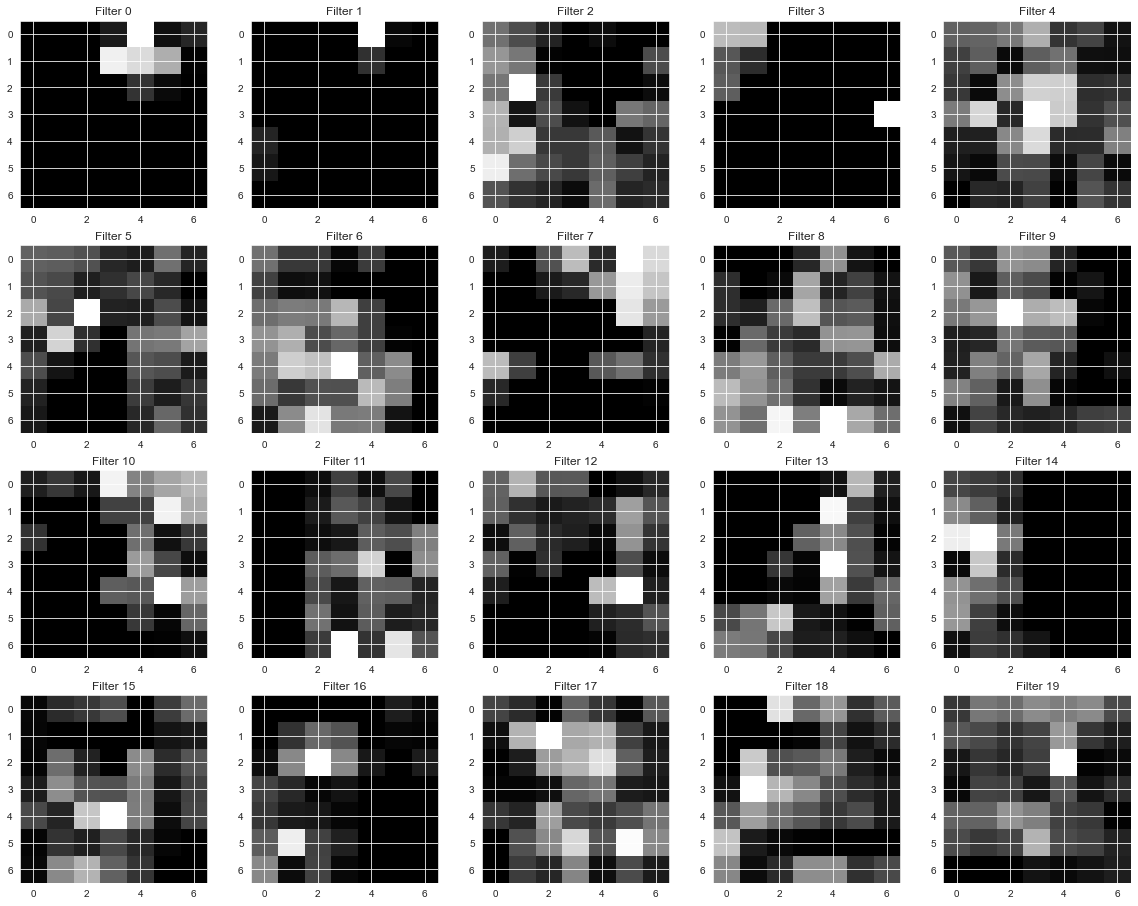

In [124]:
plotCompare(hiddens8[2], hiddens[2])

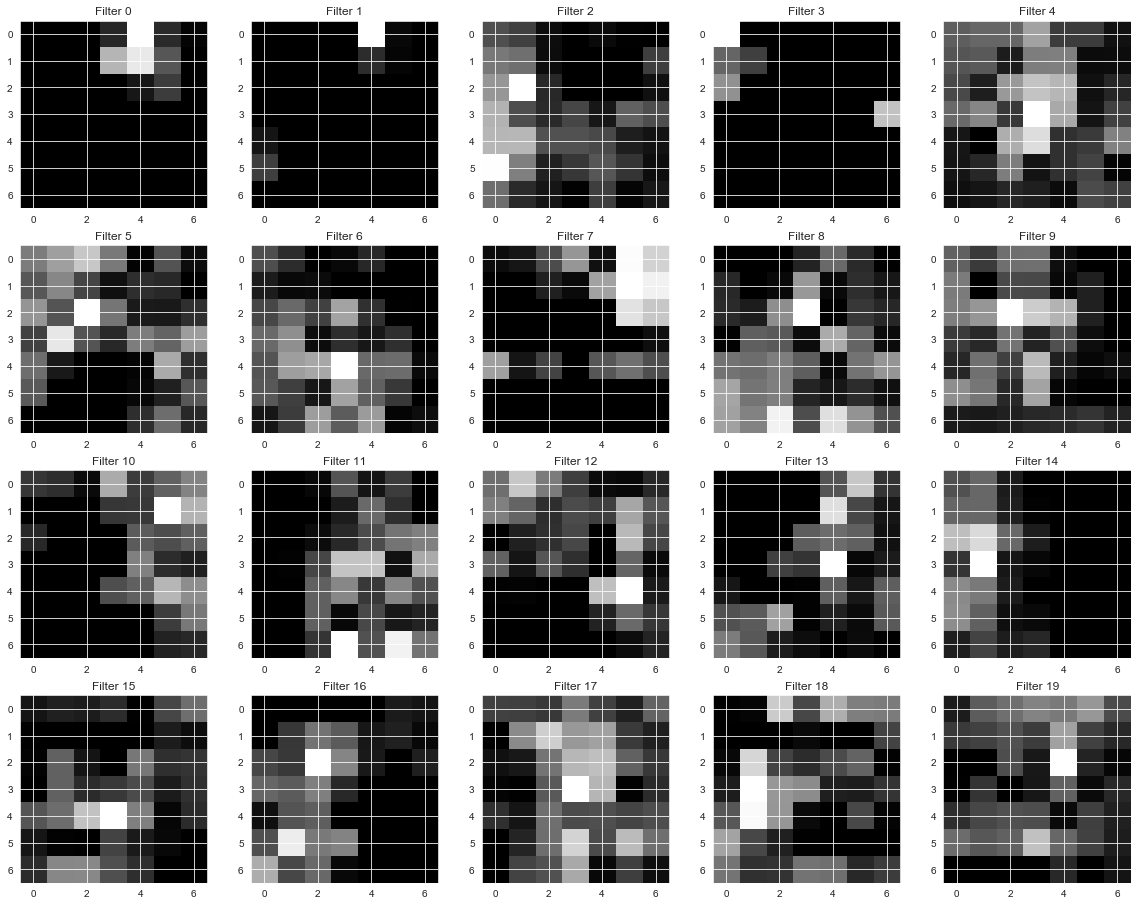

In [125]:
plotCompare(hiddens2[2], hiddens[2])